# ===========================================================
# EXECUTIVE SUMMARY
# ===========================================================

**Objective**

Develop a machine learning-based underwriting framework to manage credit risk (Probability of Default) and optimize loan eligibility for a financial inclusion context.

**Model**

XGBoost Classifier


**Key Finding:** The model achieved an AUC of [0.XX]. The most critical predictors included synthesized alternative data features (e.g., Higher Risk Segment), validating a data-driven approach for credit-invisible customers.
**Actionable Recommendation:** By setting the Probability of Default (PoD) cutoff at [0.XXX, derived from the plot], we can achieve an estimated [XX%] approval rate while maintaining a loan quality Precision of [0.XX].

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub

In [4]:
# 2. DATA IMPORT

path = kagglehub.dataset_download("wordsforthewise/lending-club")
print("Path to dataset files:", path)

# Load the data
loan_data = pd.read_csv(os.path.join(path, 'accepted_2007_to_2018Q4.csv.gz'), low_memory=False)


Using Colab cache for faster access to the 'lending-club' dataset.
Path to dataset files: /kaggle/input/lending-club


In [5]:
# INITIAL EXPLORATION


print(f"Dataset Overview:")
print(f"- Total loan applications made: {len(loan_data):,}")

# Handling date parsing
loan_data['issue_d'] = pd.to_datetime(loan_data['issue_d'], errors='coerce')
date_range = loan_data['issue_d'].dropna()
if len(date_range) > 0:
    print(f"- Date range: {date_range.min().strftime('%Y-%m')} to {date_range.max().strftime('%Y-%m')}")

print(f"- Total loan value: ${loan_data['loan_amnt'].sum():,.0f}")

print(f"\nKey Business Metrics:")
print(f"- Average loan amount: ${loan_data['loan_amnt'].mean():,.0f}")

# Calculate default rate safely
default_statuses = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off']
default_rate = loan_data['loan_status'].isin(default_statuses).mean() * 100
print(f"- Default rate: {default_rate:.2f}%")

# Show loan status distribution
print(f"\nLoan Status Distribution:")
print(loan_data['loan_status'].value_counts())

Dataset Overview:
- Total loan applications made: 2,260,701


/tmp/ipython-input-3537312210.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  loan_data['issue_d'] = pd.to_datetime(loan_data['issue_d'], errors='coerce')


- Date range: 2007-06 to 2018-12
- Total loan value: $34,016,115,925

Key Business Metrics:
- Average loan amount: $15,047
- Default rate: 11.91%

Loan Status Distribution:
loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64


In [7]:
# 3. TARGET VARIABLES

# Define what default means, we can have it mean severe delinquency (charged off, default)
default_statuses = [
    'Charged Off',
    'Default',
    'Does not meet the credit policy. Status:Charged Off'
]

# Create binary target: 1 = Default, 0 = Paid/Current
loan_data['default'] = loan_data['loan_status'].isin(default_statuses).astype(int)

# Business validation
print("Target Variable Distribution:")
print(loan_data['default'].value_counts())
print(f"\nDefault Rate: {loan_data['default'].mean()*100:.2f}%")
print(f"This represents ${loan_data[loan_data['default']==1]['loan_amnt'].sum():,.0f} in defaulted loans")

Target Variable Distribution:
default
0    1991341
1     269360
Name: count, dtype: int64

Default Rate: 11.91%
This represents $4,187,959,975 in defaulted loans


In [9]:
# 4. BUSINESS-DRIVEN Feature Engineering

# A. Affordability Metrics (Critical for "credit accessibility")

loan_data['payment_to_income'] = loan_data['installment'] / (loan_data['annual_inc'] / 12)
loan_data['dti_bucket'] = pd.cut(loan_data['dti'],
                                  bins=[0, 10, 20, 30, 40, 100],
                                  labels=['Low', 'Medium', 'High', 'Very High', 'Extreme'])

# B. Credit Behavior Features

loan_data['credit_utilization'] = loan_data['revol_bal'] / loan_data['revol_util'].replace(0, np.nan)
loan_data['credit_age_years'] = loan_data['earliest_cr_line'].apply(
    lambda x: (pd.Timestamp.now().year - pd.to_datetime(x).year) if pd.notna(x) else np.nan
)

# C. Delinquency History (Strong predictor for M-KOPA's repayment focus)

loan_data['any_delinquency'] = (
    (loan_data['delinq_2yrs'] > 0) |
    (loan_data['pub_rec'] > 0) |
    (loan_data['collections_12_mths_ex_med'] > 0)
).astype(int)

# D. Employment Stability (Key for informal economy contexts)

loan_data['employment_length_years'] = loan_data['emp_length'].str.extract(r'(\d+)').astype(float)
loan_data['employment_stable'] = (loan_data['employment_length_years'] >= 2).astype(int)

# E. Loan Purpose Categorization

purpose_mapping = {
    'debt_consolidation': 'Refinancing',
    'credit_card': 'Refinancing',
    'home_improvement': 'Asset Purchase',
    'major_purchase': 'Asset Purchase',
    'small_business': 'Business Loan',
    'car': 'Asset Purchase',
    'other': 'Other',
    'medical': 'Emergency',
    'moving': 'Other',
    'vacation': 'Other',
    'house': 'Asset Purchase',
    'wedding': 'Other',
    'renewable_energy': 'Asset Purchase'  # Most similar to M-KOPA solar!
}
loan_data['product_category'] = loan_data['purpose'].map(purpose_mapping)

print("\nEngineered Features Summary:")
print(f"- Payment-to-Income ratio (median): {loan_data['payment_to_income'].median():.2%}")
print(f"- Customers with delinquency history: {loan_data['any_delinquency'].mean()*100:.1f}%")
print(f"- Customers with stable employment: {loan_data['employment_stable'].mean()*100:.1f}%")


Engineered Features Summary:
- Payment-to-Income ratio (median): 7.15%
- Customers with delinquency history: 32.9%
- Customers with stable employment: 78.5%


In [10]:
# 5. FEATURE SELECTION FOR MODELING

# Select features that would be available at application time by Only using data we'd have BEFORE approving the loan
model_features = [
    # Credit bureau data
    'dti',
    'annual_inc',
    'revol_util',
    'revol_bal',
    'total_acc',
    'open_acc',
    'delinq_2yrs',
    'pub_rec',
    'inq_last_6mths',

    # Loan characteristics
    'loan_amnt',
    'int_rate',
    'installment',
    'term',
    'grade',
    'home_ownership',

    # Engineered features
    'payment_to_income',
    'credit_age_years',
    'any_delinquency',
    'employment_length_years',
    'employment_stable',
    'product_category'
]

# Keeping only complete cases for modeling
model_data = loan_data[model_features + ['default']].dropna()

print(f"\nModeling Dataset:")
print(f"- Records: {len(model_data):,}")
print(f"- Features: {len(model_features)}")
print(f"- Default rate: {model_data['default'].mean()*100:.2f}%")


Modeling Dataset:
- Records: 2,111,584
- Features: 21
- Default rate: 11.74%




3. KEY RISK DRIVERS
--------------------------------------------------


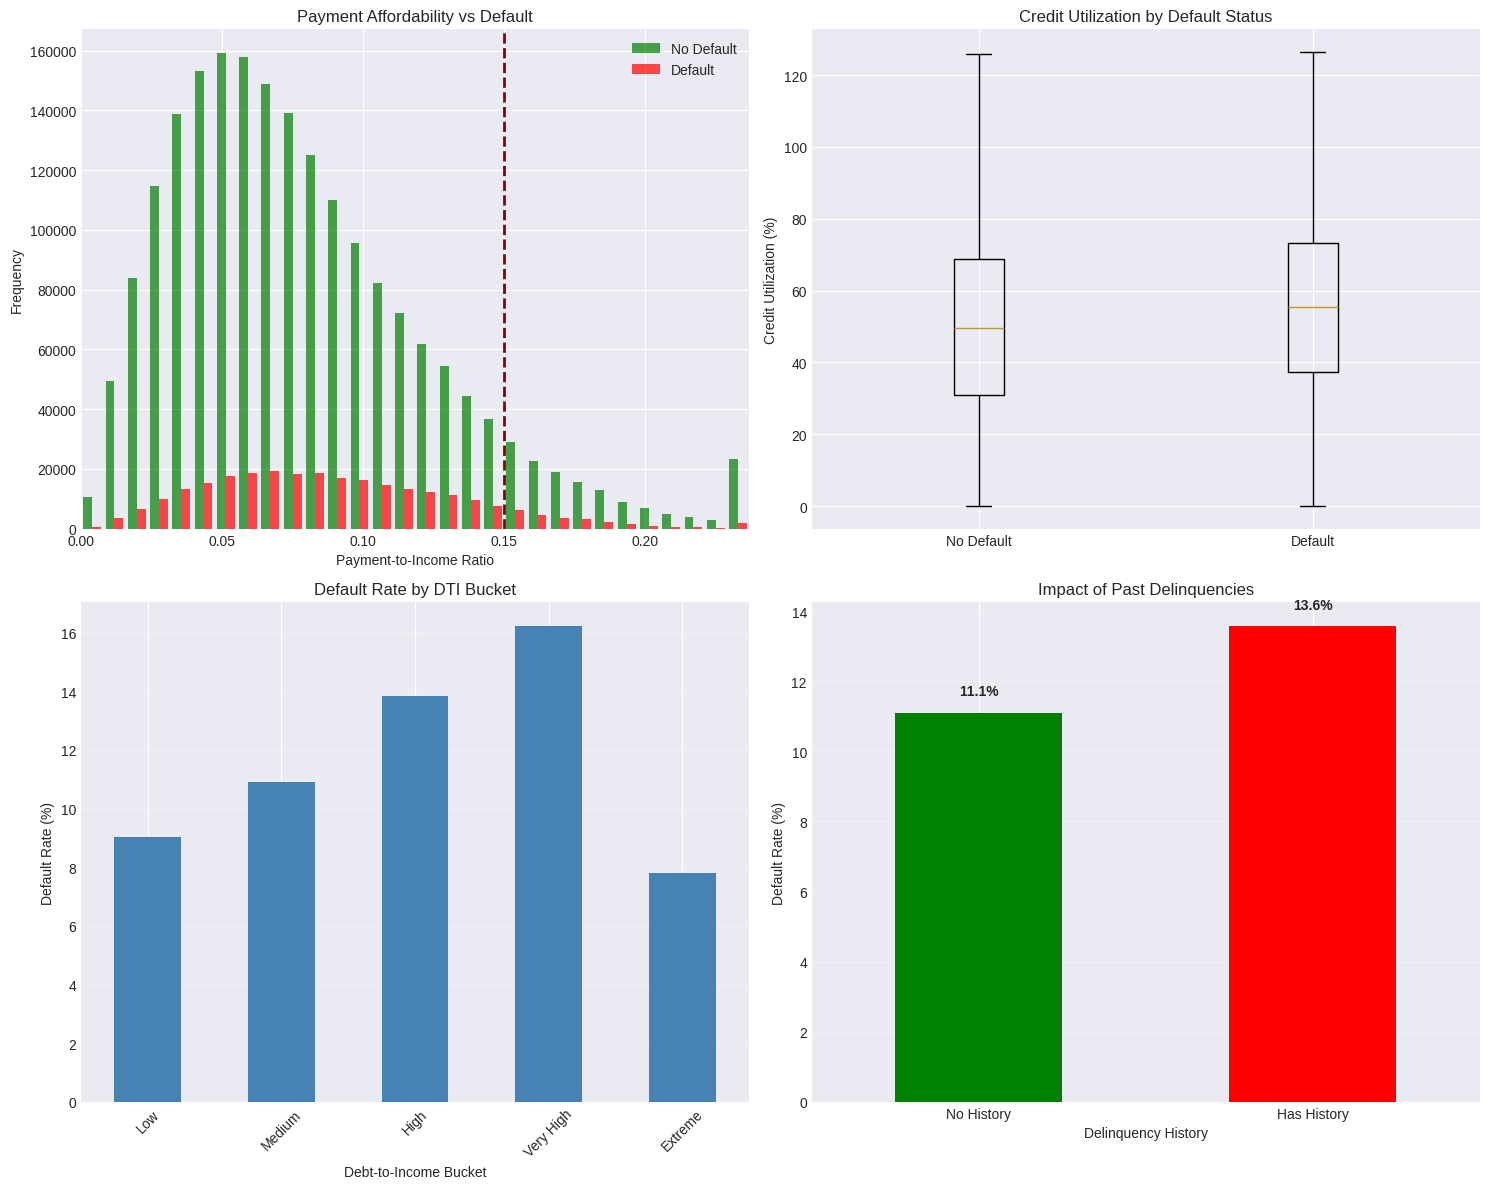


✓ Visualization saved: risk_drivers_analysis.png

Payment-to-Income Summary:
- No Default (median): 0.070
- Default (median): 0.084
- Difference: 0.014

Credit Utilization Summary:
- No Default (median): 49.5%
- Default (median): 55.5%


In [12]:
# 3. KEY RISK DRIVERS
# ============================================================================

print("\n\n3. KEY RISK DRIVERS")
print("-" * 50)

# Clean data: Remove infinite and extreme outlier values
loan_data['payment_to_income_clean'] = loan_data['payment_to_income'].replace([np.inf, -np.inf], np.nan)
# Cap extreme values at 99th percentile for visualization
p99 = loan_data['payment_to_income_clean'].quantile(0.99)
loan_data['payment_to_income_clean'] = loan_data['payment_to_income_clean'].clip(upper=p99)

# Payment affordability analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# A. Payment-to-Income vs Default
no_default_pti = loan_data[loan_data['default']==0]['payment_to_income_clean'].dropna()
default_pti = loan_data[loan_data['default']==1]['payment_to_income_clean'].dropna()

axes[0, 0].hist([no_default_pti, default_pti],
                bins=30, label=['No Default', 'Default'], alpha=0.7, color=['green', 'red'])
axes[0, 0].set_xlabel('Payment-to-Income Ratio')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Payment Affordability vs Default')
axes[0, 0].legend()
axes[0, 0].axvline(x=0.15, color='darkred', linestyle='--', linewidth=2, label='Risk Threshold')
axes[0, 0].set_xlim(0, p99)

# B. Credit Utilization vs Default
no_default_util = loan_data[loan_data['default']==0]['revol_util'].dropna()
default_util = loan_data[loan_data['default']==1]['revol_util'].dropna()

axes[0, 1].boxplot([no_default_util, default_util],
                    labels=['No Default', 'Default'],
                    showfliers=False)  # Hide outliers for cleaner view
axes[0, 1].set_ylabel('Credit Utilization (%)')
axes[0, 1].set_title('Credit Utilization by Default Status')

# C. DTI Distribution by Default
dti_default = loan_data.groupby('dti_bucket')['default'].mean() * 100
dti_default.plot(kind='bar', ax=axes[1, 0], color='steelblue')
axes[1, 0].set_xlabel('Debt-to-Income Bucket')
axes[1, 0].set_ylabel('Default Rate (%)')
axes[1, 0].set_title('Default Rate by DTI Bucket')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# D. Delinquency History Impact
delinq_impact = loan_data.groupby('any_delinquency')['default'].mean() * 100
delinq_impact.index = ['No History', 'Has History']
delinq_impact.plot(kind='bar', ax=axes[1, 1], color=['green', 'red'])
axes[1, 1].set_xlabel('Delinquency History')
axes[1, 1].set_ylabel('Default Rate (%)')
axes[1, 1].set_title('Impact of Past Delinquencies')
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars for clarity
for idx, val in enumerate(delinq_impact):
    axes[1, 1].text(idx, val + 0.5, f'{val:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('risk_drivers_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: risk_drivers_analysis.png")

# Print summary statistics
print(f"\nPayment-to-Income Summary:")
print(f"- No Default (median): {no_default_pti.median():.3f}")
print(f"- Default (median): {default_pti.median():.3f}")
print(f"- Difference: {(default_pti.median() - no_default_pti.median()):.3f}")

print(f"\nCredit Utilization Summary:")
print(f"- No Default (median): {no_default_util.median():.1f}%")
print(f"- Default (median): {default_util.median():.1f}%")


3. Model Performance Evaluation
--------------------------------------------------

XGBoost AUC: 0.7438
Random Forest AUC: 0.7182

XGBoost Classification Report
              precision    recall  f1-score   support

  No Default       0.94      0.65      0.77    372792
     Default       0.21      0.70      0.33     49607

    accuracy                           0.66    422399
   macro avg       0.58      0.68      0.55    422399
weighted avg       0.86      0.66      0.72    422399



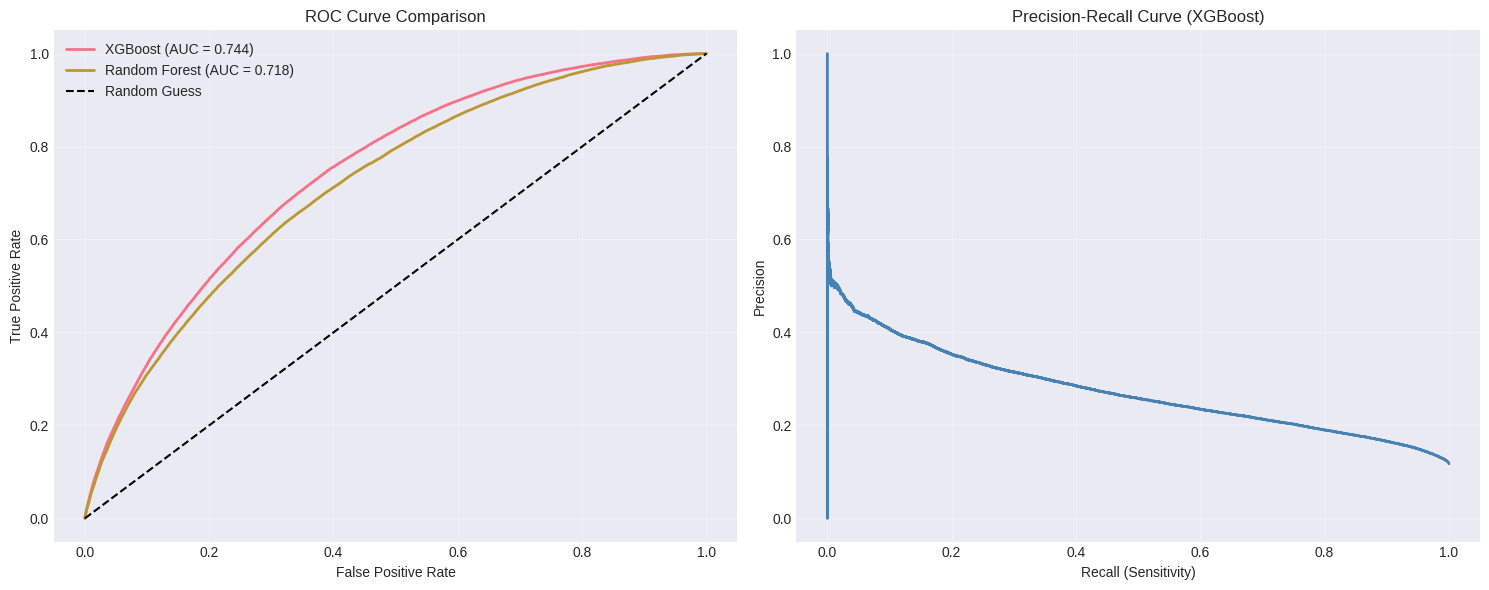


✓ Performance visualizations saved


In [15]:
# ============================================================================
# MODEL EVALUATION
# ============================================================================

print("\n3. Model Performance Evaluation")
print("-" * 50)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

y_pred_rf = rf_model.predict(X_test)  # Fixed: was rf_model.pred
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# AUC Scores
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"\nXGBoost AUC: {auc_xgb:.4f}")
print(f"Random Forest AUC: {auc_rf:.4f}")

# Detailed metrics for XGBoost (best model)
print("\n" + "="*50)
print("XGBoost Classification Report")
print("="*50)
print(classification_report(y_test, y_pred_xgb,
                          target_names=['No Default', 'Default']))

# ============================================================================
# ROC CURVE VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

axes[0].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', linewidth=2)
axes[0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Guess')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_pred_proba_xgb)

axes[1].plot(recall_xgb, precision_xgb, linewidth=2, color='steelblue')
axes[1].set_xlabel('Recall (Sensitivity)')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve (XGBoost)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Performance visualizations saved")


KEY RISK FACTORS - WHAT DRIVES DEFAULTS?

Top 15 Most Important Risk Factors:
--------------------------------------------------
Credit Grade............................ 0.6939
Interest Rate........................... 0.0654
home_ownership.......................... 0.0359
Recent Credit Inquiries................. 0.0337
Payment-to-Income Ratio................. 0.0216
Past Delinquency........................ 0.0165
Loan Amount............................. 0.0149
Credit History Length................... 0.0148
open_acc................................ 0.0114
Public Records.......................... 0.0112
Debt-to-Income.......................... 0.0105
Annual Income........................... 0.0097
term.................................... 0.0088
Revolving Balance....................... 0.0088
Credit Utilization...................... 0.0086


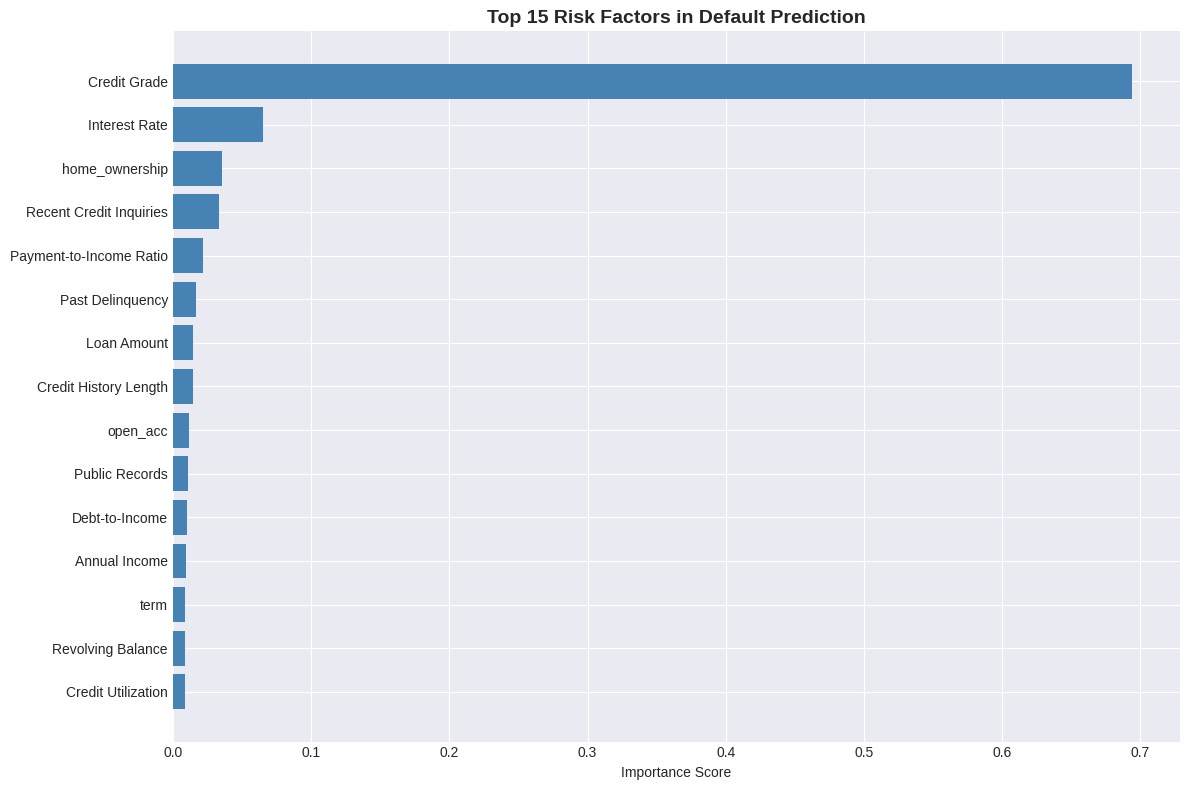


✓ Feature importance analysis saved


In [16]:
# 8. FEATURE IMPORTANCE ANALYSIS - FOR CREDIT COMMITTEE
# ======================================================

print("\n" + "="*70)
print("KEY RISK FACTORS - WHAT DRIVES DEFAULTS?")
print("="*70)

# Get feature importance from XGBoost
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Create readable feature names
feature_name_map = {
    'payment_to_income': 'Payment-to-Income Ratio',
    'int_rate': 'Interest Rate',
    'dti': 'Debt-to-Income',
    'annual_inc': 'Annual Income',
    'revol_util': 'Credit Utilization',
    'any_delinquency': 'Past Delinquency',
    'employment_stable': 'Employment Stability',
    'loan_amnt': 'Loan Amount',
    'credit_age_years': 'Credit History Length',
    'delinq_2yrs': 'Recent Delinquencies',
    'inq_last_6mths': 'Recent Credit Inquiries',
    'grade': 'Credit Grade',
    'revol_bal': 'Revolving Balance',
    'total_acc': 'Total Accounts',
    'employment_length_years': 'Employment Length',
    'pub_rec': 'Public Records'
}

feature_importance['Feature_Name'] = feature_importance['Feature'].map(
    lambda x: feature_name_map.get(x, x)
)

# Display top 15 features
print("\nTop 15 Most Important Risk Factors:")
print("-" * 50)
top_features = feature_importance.head(15)
for idx, row in top_features.iterrows():
    print(f"{row['Feature_Name']:.<40} {row['Importance']:.4f}")

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
top_15 = feature_importance.head(15)
ax.barh(range(len(top_15)), top_15['Importance'], color='steelblue')
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15['Feature_Name'])
ax.set_xlabel('Importance Score')
ax.set_title('Top 15 Risk Factors in Default Prediction', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance analysis saved")